-------------------------------------------------------------------
**TD DSA 2021 de Antoine Ly   -   rapport de Fabien Faivre**
-------------------------     -------------------------------------

# Un dernier Essai : BERT

Après avoir utilisé directement les modèles préentrainé, je souhaitais essayer d'ajuster véritablement un modèle de Deep Learning.

J'ai alors trouvé un article sur `medium` présentant une telle adaptation :

source : https://scottmduda.medium.com/fine-tuning-language-models-for-sentiment-analysis-91db72396549

github : https://github.com/dontmindifiduda/financial_statement_sentiment_analysis/

La logique consiste à aller chercher un modèle préentrainé sur HuggingFace. Ici trous variantes sont testées :

- `BERT` : le modèle de référence de l'encodage bidirectionnel initialement publié par Google
- `DistilBERT` : la version allégée de `BERT` pour des performances a priori comparables
- `RoBERTa` : la variante de Facebook de `BERT` renonçant à l'objectif de prédiction de la phrase suivante et ayant été entraîné avec plus de données et des séquences d'apprentissage plus longues


In [1]:
import numpy as np 
import pandas as pd 

import os
import re
import time
import datetime
import string

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from collections import Counter, defaultdict

import transformers
from transformers import BertModel, BertTokenizer, DistilBertTokenizer, RobertaModel, RobertaTokenizer
from transformers import AutoConfig, AutoModel, AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn, optim
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

import mlflow

import gc


## Chargement des données

In [2]:
# On Importe les données

#df
df_train=pd.read_parquet('/mnt/data/interim/df_train.gzip')
df_val=pd.read_parquet('/mnt/data/interim/df_val.gzip')
df_test=pd.read_parquet('/mnt/data/interim/df_test.gzip')

#X
X_train=pd.read_parquet('/mnt/data/interim/X_train.gzip')
X_val=pd.read_parquet('/mnt/data/interim/X_val.gzip')
X_test=pd.read_parquet('/mnt/data/interim/X_test.gzip')

X_train_prepro=pd.read_parquet('/mnt/data/interim/X_train_prepro.gzip')
X_val_prepro=pd.read_parquet('/mnt/data/interim/X_val_prepro.gzip')
X_test_prepro=pd.read_parquet('/mnt/data/interim/X_test_prepro.gzip')

#y
y_train=pd.read_parquet('/mnt/data/interim/y_train.gzip')
y_val=pd.read_parquet('/mnt/data/interim/y_val.gzip')
y_test=pd.read_parquet('/mnt/data/interim/y_test.gzip')

In [42]:
res_fin2 = pd.read_parquet('/mnt/data/processed/res_fin2.gzip')

## Définition du Device à utiliser et fixation de la graîne

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

RANDOM_SEED = 73
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
df = pd.concat([df_train, df_val, df_test], axis=0)


In [5]:

df['num_char'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(x.split()))

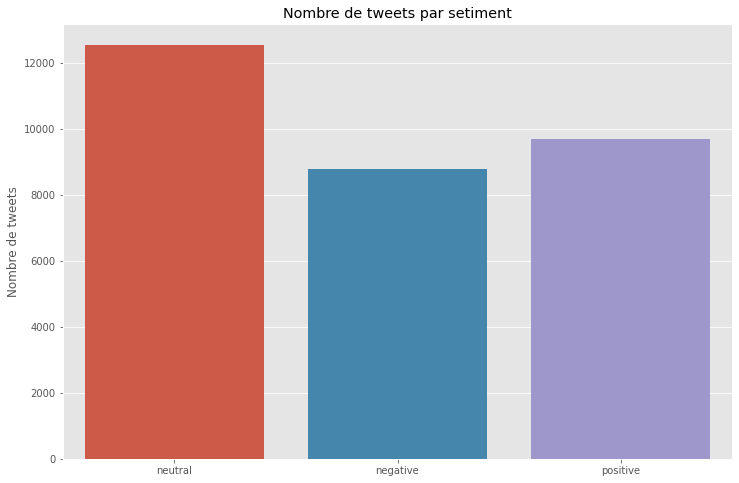

In [40]:
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(x='sentiment', data=df)
plt.xlabel('')
plt.ylabel('Nombre de tweets')
plt.title('Nombre de tweets par setiment')
plt.show()

In [39]:
print('Plus long tweet : ', df['num_words'].max(), 'mots.')

Plus long tweet :  33 mots.


In [38]:
print('Tweet le plus court : ', df['num_words'].min(), 'mots.')

Tweet le plus court :  1 mots.


## Exploration pour l'analyse de sentiment

### Code générique

In [9]:
MAX_LENGTH = 64
BATCH_SIZE = 16
NUM_CLASSES = 3
EPOCHS = 5
DROPOUT_PROB = 0.1
WEIGHT_DECAY = 0.01
NFOLDS = 10
LEARNING_RATE = 2e-5

In [10]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

La classe suivante permet de charger les données et tokeniser les tweets

In [11]:
class TweetDataset(Dataset):
    
    def __init__(self, tweets, labels, tokenizer, max_length):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        
        return len(self.tweets)
    
    def __getitem__(self, idx):
        
        tweet = str(self.tweets[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            tweet,
            max_length=self.max_length,
            padding='max_length',
            add_special_tokens=True, 
            return_token_type_ids=False,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'  
        ) 
        
        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

Transforme les jeux de données. Les données sont tronquées au delà de `MAX_LENGTH`

In [12]:
def create_dataset(df, tokenizer, max_length):
    ds = TweetDataset(tweets=df['text'].to_numpy(),
                          labels=df['sentiment'].to_numpy(),
                          tokenizer=tokenizer,
                          max_length=max_length)
    return ds

def create_dataloader(ds, batch_size):
    return DataLoader(ds, batch_size)

Le code suivant crée deux variantes d'évaluation de modèles :

- `single model performance` : analyse directement les résultats d'un unique modèle

- `cv_ensemble_performance` : crée les prédictions d'un ensemble modèle. Utilisé en liaison avec l'analyse 10 fold : les modèles sur chaque fold sont considérés comme indépendants et combiné pour déterminer la prédiction finale

In [13]:
def cv_ensemble_performance(preds, labels):
    preds = np.array(preds)
    summed = np.sum(preds, axis=0)
    preds = np.argmax(summed, axis=1)
    print(confusion_matrix(y_true=labels, y_pred=preds))
    print('')
    print(classification_report(y_true=labels, y_pred=preds, digits=3, target_names=le.classes_))
    
def single_model_performance(preds, labels):
    print(confusion_matrix(y_true=labels, y_pred=preds))
    print('')
    print(classification_report(y_true=labels, y_pred=preds, digits=3, target_names=le.classes_))

`train_model` entraine le modèle sur chaque batch du jeu de données (extraits par le DalaLoader)

In [14]:
def train_model(model, device, data_loader, loss_function, 
                optimizer, scheduler, n_examples):
    
    model = model.train()
    losses = []
    correct_preds = 0
    complete_preds = []
    complete_labels = []
    
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
        _, preds = torch.max(outputs, dim=1)
        loss = loss_function(outputs, labels)
        complete_preds.append(preds.data.cpu().numpy().tolist())
        complete_labels.append(labels.data.cpu().numpy().tolist())
        correct_preds += torch.sum(preds == labels)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    complete_preds_flat = [x for y in complete_preds for x in y]
    complete_labels_flat = [x for y in complete_labels for x in y]
    acc_score = accuracy_score(y_true=complete_labels_flat, 
                             y_pred=complete_preds_flat)
    return acc_score, np.mean(losses)

`eval_model` : évalue un modèle sur un jeu de test pour chaque batch du jeu de test

In [15]:
def eval_model(model, device, data_loader, loss_function, n_examples):
    model = model.eval()
    
    losses = []
    correct_preds = 0
    complete_preds = []
    complete_labels = []
    complete_outputs = []
    
    with torch.no_grad():
        for item in data_loader:
            input_ids = item['input_ids'].to(device)
            attention_mask = item['attention_mask'].to(device)
            labels = item['labels'].to(device)

            outputs = model(input_ids=input_ids, 
                            attention_mask=attention_mask)
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_function(outputs, labels)
            
            correct_preds += torch.sum(preds == labels)
            complete_preds.append(preds.data.cpu().numpy().tolist())
            complete_labels.append(labels.data.cpu().numpy().tolist())
            complete_outputs.append(outputs.tolist())
            losses.append(loss.item())
        
        accuracy = correct_preds.double() / n_examples
        complete_preds_flat = [x for y in complete_preds for x in y]
        complete_labels_flat = [x for y in complete_labels for x in y]
        complete_outputs_flat = [x for y in complete_outputs for x in y]

        acc_score = accuracy_score(y_true=complete_labels_flat, 
                             y_pred=complete_preds_flat)
        
        return_items = (acc_score, 
                        np.mean(losses),
                        complete_labels_flat,
                        complete_preds_flat, 
                        complete_outputs_flat)
        
        return return_items

`plot_cm` permet de tracer la matrice de confusion du modèle

In [16]:
def plot_cm(y_test, y_pred, target_names=[-1, 0, 1], 
            figsize=(5,3)):
    """Create a labelled confusion matrix plot."""
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='g', cmap='BuGn', cbar=False, 
                ax=ax)
    ax.set_title('Confusion matrix')
    ax.set_xlabel('Predicted')
    ax.set_xticklabels(target_names)
    ax.set_ylabel('Actual')
    ax.set_yticklabels(target_names, 
                       fontdict={'verticalalignment': 'center'});

On initialise MLFlow pour pytorch

In [17]:
import mlflow.pytorch
from mlflow.tracking import MlflowClient

`train_fold` permet d'entrainer un modèle sur un unique fold. Les résiltats sont stockés dans MLFlow. Les résultats sont évalués à l'issue de chaque EPOCH.

In [18]:
def train_fold(mlf_XP, xp_name_iter, epochs, model, device, train_dataloader, 
               val_dataloader, test_dataloader, loss_fn, optimizer, 
               scheduler, model_save_name, n_train, n_val, single_model=True):
    
    
    mlflow.set_experiment(mlf_XP)

    
    
    start_time = time.time()
    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(epochs):
        run_name = xp_name_iter + '_' + str(epoch+1)
        with mlflow.start_run(run_name = run_name):
            epoch_start_time = time.time()
            print('Epoch ', epoch+1, '/', epochs)
            print('-'*50)

            training_output = train_model(model, 
                                          device, 
                                          train_dataloader, 
                                          loss_fn, 
                                          optimizer, 
                                          scheduler, 
                                          n_train)

            train_acc, train_loss = training_output

            val_output = eval_model(model, 
                                    device, 
                                    val_dataloader, 
                                    loss_fn, 
                                    n_val)

            val_acc, val_loss, _, val_preds, val_outputs = val_output

            history['train_accuracy'].append(train_acc)
            history['train_loss'].append(train_loss)
            history['val_accuracy'].append(val_acc)
            history['val_loss'].append(val_loss)
            history['val_preds'].append(val_preds)
            
            mlflow.log_metrics({'epoch': epoch, 'train_acc' : train_acc, 'train_loss': train_loss, 'val_acc': val_acc, 'val_loss' : val_loss })
            
            mlflow.pytorch.log_model(model, run_name, conda_env='/mnt/configs/conda.yml')
            
            if val_acc > best_accuracy:
                torch.save(model.state_dict(), model_save_name)
                best_accuracy = val_acc
                best_preds = val_preds
                best_outputs = val_outputs
                best_epoch = epoch
                

            print('Train Loss: ', 
                  train_loss, 
                  ' | ', 
                  'Train Accuracy: ', 
                  train_acc)
            print('Val Loss: ', 
                  val_loss, 
                  ' | ', 
                  'Val Accuracy: ', 
                  val_acc)
            elapsed_time = format_time(time.time() - epoch_start_time)
            print('Epoch Train Time: ', 
                  elapsed_time)
            print('\n')
            
            mlflow.set_tag(key="elapsed_time", value=elapsed_time)   

    print('Finished Training.')   
    print('Fold Train Time: ', format_time(time.time() - start_time))
    print('\n')
                  
    if single_model:
        test_acc, test_loss, test_actuals, test_preds, test_outputs = eval_model(model, 
                                                    device, 
                                                    test_dataloader, 
                                                    loss_function, 
                                                    len(df_test))

        single_model_performance(test_preds, df_test['sentiment'].values)
        plot_cm(test_actuals, test_preds)
        f1_macro_test = f1_score(test_actuals, test_preds, average='macro')
        run_name = xp_name_iter + '_best'
        with mlflow.start_run(run_name = run_name):
            mlflow.log_metrics({'train_acc' : history['train_accuracy'][epoch], 'train_loss': history['train_accuracy'][epoch], 'val_acc': history['val_accuracy'][epoch], 'val_loss' : history['train_accuracy'][epoch], 'test_acc': test_acc, 'test_loss': test_loss, 'f1_test':f1_macro_test})
            mlflow.pytorch.log_model(model, run_name, conda_env='/mnt/configs/conda.yml')

                  
    return history, best_preds, best_outputs

La fonction suivante exploite l'entraîneme,nt sur un fold pour l'étendre sur du k-fold

In [19]:
def get_oof_and_test_preds(mlf_XP, model_type, tokenizer, 
                           train_df, test_df, single_model=False):
    
    
    mlflow.set_experiment(mlf_XP)
    
    
    oof_preds = []
    oof_outputs = []
    oof_preds_indices = []
    test_preds_list = []
    test_outputs_list = []
    history_list = []
    start_time = time.time()
    
    fold = 0
    
    x_train = train_df['text']
    y_train = train_df['sentiment']

    for train_index, val_index in skf.split(x_train, y_train):
        print('Fold: {}'.format(fold+1))
        
        x_tr = x_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_va = x_train.iloc[val_index]
        y_va = y_train.iloc[val_index]
        
        train = pd.DataFrame(list(zip(x_tr, y_tr)), 
                             columns=['text', 'sentiment'])
        val = pd.DataFrame(list(zip(x_va, y_va)), 
                           columns=['text', 'sentiment'])

        train_ds = create_dataset(train, tokenizer, MAX_LENGTH)
        val_ds = create_dataset(val, tokenizer, MAX_LENGTH)
        test_ds = create_dataset(test_df, tokenizer, MAX_LENGTH)
        

        if model_type == 'bert':
            model = BERTSentimentClassifier(NUM_CLASSES)
            model = model.to(device)
        elif model_type == 'distilbert':
            model = DistilBertForSequenceClassification(pretrained_model_name=DISTILBERT_MODEL_NAME, 
                                                        num_classes=NUM_CLASSES)
            model = model.to(device)
        elif model_type == 'roberta':
            model = RobertaSentimentClassifier(n_classes=NUM_CLASSES)
            model = model.to(device)
        
        train_loader = create_dataloader(train_ds, BATCH_SIZE)
        val_loader = create_dataloader(val_ds, BATCH_SIZE)
        test_loader = create_dataloader(test_ds, BATCH_SIZE)
        
        training_steps = len(train_loader.dataset) * EPOCHS
        warmup_steps = int(0.1 * training_steps)
        optimizer = AdamW(model.parameters(), 
                          lr=LEARNING_RATE, 
                          weight_decay=WEIGHT_DECAY, 
                          correct_bias=True)
        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps=warmup_steps, 
                                                    num_training_steps=training_steps)
        
        model_save_name = '{}_fold_{}.bin'.format(model_type, fold)
        
        history, preds, outputs = train_fold(mlf_XP = mlf_XP, 
                                             xp_name_iter = model_type + '_Fold' + str(fold+1),
                                             epochs=EPOCHS,
                                             model=model, 
                                             device=device, 
                                             train_dataloader=train_loader, 
                                             val_dataloader=val_loader,
                                             test_dataloader=test_loader,
                                             loss_fn=loss_function,
                                             optimizer=optimizer,
                                             scheduler=scheduler,
                                             model_save_name=model_save_name,
                                             n_train=len(train),
                                             n_val=len(val),
                                             single_model=False
                                            )
        
        history_list.append(history)
        oof_preds.append(preds)
        oof_outputs.append(outputs)
        oof_preds_indices.append(val_index)
        
        test_acc, test_loss, test_actuals, test_preds, test_outputs = eval_model(model, 
                                                                                device, 
                                                                                test_loader, 
                                                                                loss_function, 
                                                                                len(test_df))
        test_preds_list.append(test_preds)
        test_outputs_list.append(test_outputs)
        
        fold += 1

    print(str(NFOLDS), 'Fold CV Train Time: ', format_time(time.time() - start_time))

    return history_list, test_outputs_list

La fonction de perte choisie est la cross entropy.
La perte de Cross-entropy croit lorsque la probabilité prédite pour une classe diverge du label réel. Ainsi, uen prédiction de 0,12 alors que le label réel est 1 se traduirait en une forte pénalisation. Un modèle parfait aurait une log loss de 0.

In [20]:
loss_function = nn.CrossEntropyLoss().to(device)

Pour la féinition des k fold on efefctue un échantillonnage stratifié afin de conserver la proportion de chaque classe.

In [21]:
skf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=RANDOM_SEED)

### Données

:::{warning}
On est obligé de recoder les sorties car laisser un label cible négatif génère une erreur `CUDA error: device-side assert triggered`
cf [lien](https://discuss.pytorch.org/t/runtimeerror-cuda-error-device-side-assert-triggered/34213/8)
:::

In [22]:
le = LabelEncoder()
df_train['sentiment'] = le.fit_transform(df_train['sentiment'])
df_val['sentiment'] = le.fit_transform(df_val['sentiment'])
df_test['sentiment'] = le.fit_transform(df_test['sentiment'])

In [81]:
df_train

,text,sentiment
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0
...,...,...
21979,No allowed a calculator for this exam despite ...,0
21980,Haha same as miine,1
21981,"i`m sorry people are so rude to you, isaac, ...",0
21982,"why? i enjoy fancy meals on my own smtimes, t...",2


In [82]:
df_val

,text,sentiment
21984,_JessicaB_**** yip.....aw gonna miss them on bb,0
21985,_violence heyyyy babyy,0
21986,Up at 6am on Sunday... Going to meet my mom fo...,1
21987,so the Today show still hasn`t gotten in touch...,1
21988,Just checked email and got a follower withb sa...,1
...,...,...
27475,wish we could come see u on Denver husband l...,0
27476,I`ve wondered about rake to. The client has ...,0
27477,Yay good for both of you. Enjoy the break - y...,2
27478,But it was worth it ****.,2


In [25]:
df_train_full = pd.concat([df_train, df_val])
df_train_full

,text,sentiment
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0
...,...,...
27475,wish we could come see u on Denver husband l...,0
27476,I`ve wondered about rake to. The client has ...,0
27477,Yay good for both of you. Enjoy the break - y...,2
27478,But it was worth it ****.,2


### BERT

#### Single Model

Beaucoup d'allers retours ont été faits. Afin d'éviter de staurer la mémoir ede la carte graphique il est nécessire de vider la mémoir cache régulièrement.

In [31]:
del distilbert_model
gc.collect()
torch.cuda.empty_cache()


On utilise un modèle BERT classique

In [32]:
BERT_MODEL_NAME = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

On créée un DataLoader adapté au tokenizer de BERT

In [33]:
bert_train_ds = create_dataset(df_train, bert_tokenizer, MAX_LENGTH)
bert_test_ds = create_dataset(df_test, bert_tokenizer, MAX_LENGTH)
bert_val_ds = create_dataset(df_val, bert_tokenizer, MAX_LENGTH)

bert_train_dataloader = create_dataloader(bert_train_ds, BATCH_SIZE)
bert_test_dataloader = create_dataloader(bert_test_ds, BATCH_SIZE)
bert_val_dataloader = create_dataloader(bert_val_ds, BATCH_SIZE)

In [34]:
class BERTSentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(BERTSentimentClassifier, self).__init__()
        self.model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=False) #ATTENTION : il faut rajouter return_dict=False ici cf https://huggingface.co/transformers/migration.html
        self.drop = nn.Dropout(DROPOUT_PROB)
        self.output = nn.Linear(self.model.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.model(
            input_ids = input_ids,
            attention_mask=attention_mask
        )

        output = self.drop(pooled_output)
        
        return self.output(output)


On charge le modèle BERT. Ce faisant on écrase la dernière couche du modèle qu'on réentraînera

In [35]:
bert_model = BERTSentimentClassifier(NUM_CLASSES)
bert_model = bert_model.to(device)

On définit le moteur d'optimisation

In [36]:
training_steps = len(bert_train_dataloader.dataset) * EPOCHS

bert_optimizer = AdamW(bert_model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY, 
                       correct_bias=True)

warmup_steps = int(0.1 * training_steps)
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                                 num_warmup_steps=warmup_steps, 
                                                 num_training_steps=training_steps)

On commence par l'ajustement d'un modèle BERT sur le jeu de données train

Epoch  1 / 5
--------------------------------------------------
Train Loss:  0.9318898132361005  |  Train Accuracy:  0.5406659388646288
Val Loss:  0.6341141717031945  |  Val Accuracy:  0.7387190684133915
Epoch Train Time:  0:03:58


Epoch  2 / 5
--------------------------------------------------
Train Loss:  0.5870891877136897  |  Train Accuracy:  0.761735807860262
Val Loss:  0.5520704225745312  |  Val Accuracy:  0.7720160116448326
Epoch Train Time:  0:03:59


Epoch  3 / 5
--------------------------------------------------
Train Loss:  0.4959308845160483  |  Train Accuracy:  0.8064501455604076
Val Loss:  0.5590653404766737  |  Val Accuracy:  0.777292576419214
Epoch Train Time:  0:04:00


Epoch  4 / 5
--------------------------------------------------
Train Loss:  0.4160484819113124  |  Train Accuracy:  0.8476619359534207
Val Loss:  0.6347552118822932  |  Val Accuracy:  0.772197962154294
Epoch Train Time:  0:03:58


Epoch  5 / 5
--------------------------------------------------
Train L

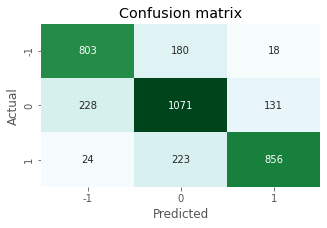

In [37]:
bert_single_model_items = train_fold(mlf_XP='BERT', 
                                     xp_name_iter='BERT',
                                     epochs=EPOCHS, 
                                     model=bert_model, 
                                     device=device, 
                                     train_dataloader=bert_train_dataloader, 
                                     val_dataloader=bert_val_dataloader,
                                     test_dataloader=bert_test_dataloader,
                                     loss_fn=loss_function,
                                     optimizer=bert_optimizer,
                                     scheduler=bert_scheduler,
                                     model_save_name='bert_best_model.bin',
                                     n_train=len(df_train),
                                     n_val=len(df_val),
                                     single_model=True
                                    )

:::{note}
Le modèle BERT arrive à un f& macro de **77,7%** sur le jeu de test et se classe directement en tête des modèles
:::

In [43]:
item = pd.DataFrame([['BERT', 0.777]], columns=['modèle', 'f1_macro_test'])

item

,modèle,f1_macro_test
0,BERT,0.777


In [46]:
res_fin=res_fin2.append(item).sort_values(by='f1_macro_test',ascending=False)

In [47]:
res_fin

,modèle,f1_macro_val,f1_macro_test
0,BERT,NaN,0.777000
0,roBERTa_xgb_opti_,0.759147,0.759953
1,roBERTa_Blob_Vader_RF_opti_,0.756699,0.750216
2,roBERTa_RF_opti_,0.746630,NaN
3,TfIdf_LR_opti_modif_seuil,0.709477,NaN
4,base_TfIdf_RF_prepro_,0.707919,NaN
5,base_TfIdf_RF_prepro_opti_,0.706432,NaN
6,roBERTa_RF_,0.705912,NaN
7,TfIdf_LR_opti_,0.699877,NaN
8,TfIdf_LR_prepro_opti_,0.698565,NaN


### DistilBERT

On reprend ici la même logique que pour BERT

#### Single Model

In [23]:
DISTILBERT_MODEL_NAME = 'distilbert-base-uncased'
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(DISTILBERT_MODEL_NAME)

In [24]:
distilbert_train_ds = create_dataset(df_train, distilbert_tokenizer, MAX_LENGTH)
distilbert_test_ds = create_dataset(df_test, distilbert_tokenizer, MAX_LENGTH)
distilbert_val_ds = create_dataset(df_val, distilbert_tokenizer, MAX_LENGTH)

distilbert_train_dataloader = create_dataloader(distilbert_train_ds, BATCH_SIZE)
distilbert_test_dataloader = create_dataloader(distilbert_test_ds, BATCH_SIZE)
distilbert_val_dataloader = create_dataloader(distilbert_val_ds, BATCH_SIZE)

In [25]:
distilbert_train_ds

In [26]:
class DistilBertForSequenceClassification(nn.Module):

    def __init__(self, pretrained_model_name, num_classes):

        super().__init__()

        config = AutoConfig.from_pretrained(pretrained_model_name, num_labels=num_classes)

        self.distilbert = AutoModel.from_pretrained(pretrained_model_name, config=config)
        self.pre_classifier = nn.Linear(config.dim, config.dim)
        self.classifier = nn.Linear(config.dim, num_classes)
        self.dropout = nn.Dropout(config.seq_classif_dropout)

    def forward(self, input_ids, attention_mask=None, head_mask=None):

        assert attention_mask is not None, "No Attention Mask"
        distilbert_output = self.distilbert(input_ids=input_ids,
                                            attention_mask=attention_mask,
                                            head_mask=head_mask)

        hidden_state = distilbert_output[0]  
        pooled_output = hidden_state[:, 0] 
        pooled_output = self.pre_classifier(pooled_output)  
        pooled_output = nn.ReLU()(pooled_output)  
        pooled_output = self.dropout(pooled_output)  
        logits = self.classifier(pooled_output)  

        return logits

In [27]:
distilbert_model = DistilBertForSequenceClassification(pretrained_model_name=DISTILBERT_MODEL_NAME, num_classes=NUM_CLASSES)
distilbert_model = distilbert_model.to(device)

In [28]:
training_steps = len(distilbert_train_dataloader.dataset) * EPOCHS

distilbert_optimizer = AdamW(distilbert_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, correct_bias=True)
distilbert_scheduler = get_linear_schedule_with_warmup(distilbert_optimizer, num_warmup_steps=int(0.1 * training_steps), num_training_steps=training_steps)

In [29]:
device

device(type='cuda')

Epoch  1 / 5
--------------------------------------------------
Train Loss:  0.9396719512417153  |  Train Accuracy:  0.5367540029112081
Val Loss:  0.6267227158816748  |  Val Accuracy:  0.7505458515283843
Epoch Train Time:  0:02:09


Epoch  2 / 5
--------------------------------------------------
Train Loss:  0.5887683325784696  |  Train Accuracy:  0.7622361717612809
Val Loss:  0.5463424418987923  |  Val Accuracy:  0.7736535662299855
Epoch Train Time:  0:02:07


Epoch  3 / 5
--------------------------------------------------
Train Loss:  0.510728445874725  |  Train Accuracy:  0.7969887190684134
Val Loss:  0.5309577705988358  |  Val Accuracy:  0.7862081513828238
Epoch Train Time:  0:02:07


Epoch  4 / 5
--------------------------------------------------
Train Loss:  0.44334969244723843  |  Train Accuracy:  0.8310134643377002
Val Loss:  0.578479872539986  |  Val Accuracy:  0.7860262008733624
Epoch Train Time:  0:02:07


Epoch  5 / 5
--------------------------------------------------
Train

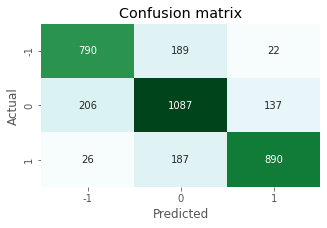

In [30]:
distilbert_history, distilbert_preds, distilbert_outputs = train_fold(mlf_XP='BERT', 
                                                                       xp_name_iter='DistilBERT',
                                                                       epochs=EPOCHS,
                                                                       model=distilbert_model,
                                                                       device=device, 
                                                                       train_dataloader=distilbert_train_dataloader, 
                                                                       val_dataloader=distilbert_val_dataloader,
                                                                       test_dataloader=distilbert_test_dataloader,
                                                                       loss_fn=loss_function,
                                                                       optimizer=distilbert_optimizer,
                                                                       scheduler=distilbert_scheduler,
                                                                       model_save_name='distilbest_best_model.bin',
                                                                       n_train=len(df_train),
                                                                       n_val=len(df_val),
                                                                       single_model=True
                                                                      )

:::{note}
DistilBERT tient toutes ses promesses, il présente un f1 macro de **78,7%** pour un temps 2 fois moindre
:::

In [48]:
item = pd.DataFrame([['DistilBERT', 0.787]], columns=['modèle', 'f1_macro_test'])

item

,modèle,f1_macro_test
0,DistilBERT,0.787


In [49]:
res_fin=res_fin.append(item).sort_values(by='f1_macro_test',ascending=False)

In [50]:
res_fin

,modèle,f1_macro_val,f1_macro_test
0,DistilBERT,NaN,0.787000
0,BERT,NaN,0.777000
0,roBERTa_xgb_opti_,0.759147,0.759953
1,roBERTa_Blob_Vader_RF_opti_,0.756699,0.750216
2,roBERTa_RF_opti_,0.746630,NaN
3,TfIdf_LR_opti_modif_seuil,0.709477,NaN
4,base_TfIdf_RF_prepro_,0.707919,NaN
5,base_TfIdf_RF_prepro_opti_,0.706432,NaN
6,roBERTa_RF_,0.705912,NaN
7,TfIdf_LR_opti_,0.699877,NaN


#### 10-Fold CV

Le temps d'ajustement étant relativement court, on peut se permettre de faire un modèle ensembliste à partir d'un ajustement 10-fold

In [74]:
distilbert_history, distilbert_test_outputs = get_oof_and_test_preds(mlf_XP='DistilBERT_10Fold',
                                                                     model_type='distilbert', 
                                                                     tokenizer=distilbert_tokenizer, 
                                                                     train_df=df_train_full, 
                                                                     test_df=df_test,
                                                                     single_model=False)

Fold: 1
Epoch  1 / 5
--------------------------------------------------
Train Loss:  0.941926259658315  |  Train Accuracy:  0.522400129387029
Val Loss:  0.6203636002055434  |  Val Accuracy:  0.7558224163027657
Epoch Train Time:  0:02:25


Epoch  2 / 5
--------------------------------------------------
Train Loss:  0.580964529094073  |  Train Accuracy:  0.7636665049328805
Val Loss:  0.5477447283649167  |  Val Accuracy:  0.7776564774381368
Epoch Train Time:  0:02:18


Epoch  3 / 5
--------------------------------------------------
Train Loss:  0.5048014043286964  |  Train Accuracy:  0.7982371017305515
Val Loss:  0.545227823259179  |  Val Accuracy:  0.7900291120815138
Epoch Train Time:  0:02:16


Epoch  4 / 5
--------------------------------------------------
Train Loss:  0.44333723517084184  |  Train Accuracy:  0.8298964903768398
Val Loss:  0.5853824304893266  |  Val Accuracy:  0.7863901018922853
Epoch Train Time:  0:02:15


Epoch  5 / 5
--------------------------------------------------

In [75]:
cv_ensemble_performance(distilbert_test_outputs, df_test['sentiment'].values)

[[ 739  235   27]
 [ 148 1123  159]
 [  20  165  918]]

              precision    recall  f1-score   support

    negative      0.815     0.738     0.775      1001
     neutral      0.737     0.785     0.761      1430
    positive      0.832     0.832     0.832      1103

    accuracy                          0.787      3534
   macro avg      0.795     0.785     0.789      3534
weighted avg      0.789     0.787     0.787      3534



:::{warning}
DistilBERT 10 fold présente un f1 macro à peine amélioré **78,9%** pour un temps **11,5** fois plus important !
:::

In [51]:
item = pd.DataFrame([['DistilBERT_10-fold', 0.789]], columns=['modèle', 'f1_macro_test'])

item

,modèle,f1_macro_test
0,DistilBERT_10-fold,0.789


In [52]:
res_fin=res_fin.append(item).sort_values(by='f1_macro_test',ascending=False)

In [53]:
res_fin

,modèle,f1_macro_val,f1_macro_test
0,DistilBERT_10-fold,NaN,0.789000
0,DistilBERT,NaN,0.787000
0,BERT,NaN,0.777000
0,roBERTa_xgb_opti_,0.759147,0.759953
1,roBERTa_Blob_Vader_RF_opti_,0.756699,0.750216
2,roBERTa_RF_opti_,0.746630,NaN
3,TfIdf_LR_opti_modif_seuil,0.709477,NaN
4,base_TfIdf_RF_prepro_,0.707919,NaN
5,base_TfIdf_RF_prepro_opti_,0.706432,NaN
6,roBERTa_RF_,0.705912,NaN


### RoBERTa

Le dernier modèle testé est RoBERTa

#### Single Model

In [93]:
del bert_model
gc.collect()
torch.cuda.empty_cache()


In [95]:
ROBERTA_MODEL_NAME = 'roberta-base'
roberta_tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_MODEL_NAME)

In [96]:
roberta_train_ds = create_dataset(df_train, roberta_tokenizer, MAX_LENGTH)
roberta_test_ds = create_dataset(df_test, roberta_tokenizer, MAX_LENGTH)
roberta_val_ds = create_dataset(df_val, roberta_tokenizer, MAX_LENGTH)

roberta_train_dataloader = create_dataloader(roberta_train_ds, BATCH_SIZE)
roberta_test_dataloader = create_dataloader(roberta_test_ds, BATCH_SIZE)
roberta_val_dataloader = create_dataloader(roberta_val_ds, BATCH_SIZE)

In [97]:
class RobertaSentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(RobertaSentimentClassifier, self).__init__()
        self.model = RobertaModel.from_pretrained(ROBERTA_MODEL_NAME, return_dict=False) #ATTENTION : il faut rajouter return_dict=False ici cf https://huggingface.co/transformers/migration.html
        self.drop = nn.Dropout(DROPOUT_PROB)
        self.output = nn.Linear(self.model.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.model(
            input_ids = input_ids,
            attention_mask=attention_mask
        )
        
        output = self.drop(pooled_output)
        
        return self.output(output)

In [98]:
roberta_model = RobertaSentimentClassifier(n_classes=NUM_CLASSES)
roberta_model = roberta_model.to(device)

In [99]:
training_steps = len(roberta_train_dataloader.dataset) * EPOCHS

roberta_optimizer = AdamW(roberta_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, correct_bias=True)
roberta_scheduler = get_linear_schedule_with_warmup(roberta_optimizer, num_warmup_steps=int(0.1 * training_steps), num_training_steps=training_steps)

Epoch  1 / 5
--------------------------------------------------
Train Loss:  0.9043195859205081  |  Train Accuracy:  0.5254275836972343
Val Loss:  0.5874736773846454  |  Val Accuracy:  0.7574599708879185
Epoch Train Time:  0:09:34


Epoch  2 / 5
--------------------------------------------------
Train Loss:  0.5546561090012652  |  Train Accuracy:  0.7763373362445415
Val Loss:  0.5240757602678482  |  Val Accuracy:  0.7867540029112081
Epoch Train Time:  0:09:30


Epoch  3 / 5
--------------------------------------------------
Train Loss:  0.48944837608126573  |  Train Accuracy:  0.8069050218340611
Val Loss:  0.5171312416232255  |  Val Accuracy:  0.787117903930131
Epoch Train Time:  0:09:31


Epoch  4 / 5
--------------------------------------------------
Train Loss:  0.43777817099733385  |  Train Accuracy:  0.8314683406113537
Val Loss:  0.5419738723484929  |  Val Accuracy:  0.7860262008733624
Epoch Train Time:  0:09:28


Epoch  5 / 5
--------------------------------------------------
Tra

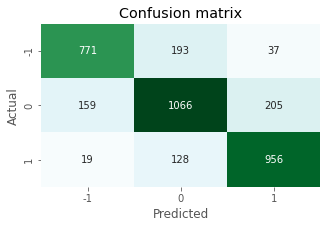

In [100]:
roberta_single_model_items = train_fold(  
                                          mlf_XP='RoBERTa', 
                                          xp_name_iter='RoBERTa',
                                          epochs=EPOCHS,
                                          model=roberta_model,
                                          device=device, 
                                          train_dataloader=roberta_train_dataloader, 
                                          val_dataloader=roberta_val_dataloader,
                                          test_dataloader=roberta_test_dataloader,
                                          loss_fn=loss_function,
                                          optimizer=roberta_optimizer,
                                          scheduler=roberta_scheduler,
                                          model_save_name='roberta_best_model.bin',
                                          n_train=len(df_train),
                                          n_val=len(df_val),
                                          single_model=True
                                         )

:::{warning}
RoBERTa est très lent à ajuster (47 min vs 10 min pour DistilBERT). Par contre il présente un f1 macro amélioré à **79,3%**
:::

In [54]:
item = pd.DataFrame([['RoBERTa', 0.793]], columns=['modèle', 'f1_macro_test'])

item

,modèle,f1_macro_test
0,RoBERTa,0.793


In [55]:
res_fin=res_fin.append(item).sort_values(by='f1_macro_test',ascending=False)

In [56]:
res_fin

,modèle,f1_macro_val,f1_macro_test
0,RoBERTa,NaN,0.793000
0,DistilBERT_10-fold,NaN,0.789000
0,DistilBERT,NaN,0.787000
0,BERT,NaN,0.777000
0,roBERTa_xgb_opti_,0.759147,0.759953
1,roBERTa_Blob_Vader_RF_opti_,0.756699,0.750216
2,roBERTa_RF_opti_,0.746630,NaN
3,TfIdf_LR_opti_modif_seuil,0.709477,NaN
4,base_TfIdf_RF_prepro_,0.707919,NaN
5,base_TfIdf_RF_prepro_opti_,0.706432,NaN


In [57]:
res_fin.to_parquet('/mnt/data/processed/res_fin3.gzip',compression='gzip')